# Introduction

This work is based on the implementation of the paper [*Personalized Federated Learning with Moreau Envelopes*](https://arxiv.org/pdf/2006.08848). The implementation can be found [here](https://github.com/CharlieDinh/pFedMe). Note that this repository not only implements pFedMe but also FedAvg and Per-FedAvg algorithms that will allow further analysis. 

In this project, we focus exclusively on the MNIST dataset. We investigate the impact of using different levels of non-iidness and the effects of data poisoning attacks.

In [1]:
from utils.plot_result_utils import *

# Baseline

In order to establish a baseline for comparison and to replicate the results of the paper, we executed the following commands:

- **Strongly Convex Case:** referred as MLR
    - pFedMe:
        ```
        python3 main.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.1 --beta 2 --lamda 15 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 main.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 main.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.03 --beta 0.003  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

- **Non-Convex Case:** referred as DNN
    - pFedMe:
        ```
        python3 main.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.05 --beta 2 --lamda 30 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 main.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 main.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --beta 0.001  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

All results are stored in the 'results_baseline' folder.

Each algorithm is executed at least 10 times, and the results are then averaged using the `average_data()` function in the [plot_utils.py](./utils/plot_utils.py) file. The averaged results are stored in the XXX_avg.h5 files, note that the averaging is done along the columns. Additionally, the results of each training round are stored in the XXX.h5 files using the `save_results()` function in the [serverbase.py](./FLAlgorithms/servers/serverbase.py) file.

In [2]:
num_users = 5
folders = ["./results_baseline/results_DNN", "./results_baseline/results_MLR"]

## Average

In [3]:
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.967495,255,0.964328,0.005871
1,pFedMe,results_DNN,0.962392,768,0.945911,0.052792
2,PerAvg_p,results_DNN,0.941550,794,0.903445,0.065206
3,FedAvg,results_DNN,0.960448,570,0.944583,0.056024
4,pFedMe_p,results_MLR,0.939390,76,0.932108,0.002517
5,pFedMe,results_MLR,0.919438,250,0.910344,0.038375
6,PerAvg_p,results_MLR,0.933477,470,0.925235,0.013431
7,FedAvg,results_MLR,0.925000,743,0.915224,0.043297


## Training rounds

In [4]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
33,FedAvg,results_DNN,0.962743,556,0.961744,0.000468
72,FedAvg,results_MLR,0.929266,780,0.928483,0.000621
23,PerAvg_p,results_DNN,0.942765,795,0.941712,0.000768
66,PerAvg_p,results_MLR,0.935745,470,0.934746,0.000694
10,pFedMe,results_DNN,0.965173,782,0.963688,0.000630
50,pFedMe,results_MLR,0.924406,433,0.923785,0.000580
0,pFedMe_p,results_DNN,0.970572,184,0.969546,0.000712
42,pFedMe_p,results_MLR,0.944114,39,0.942414,0.001208


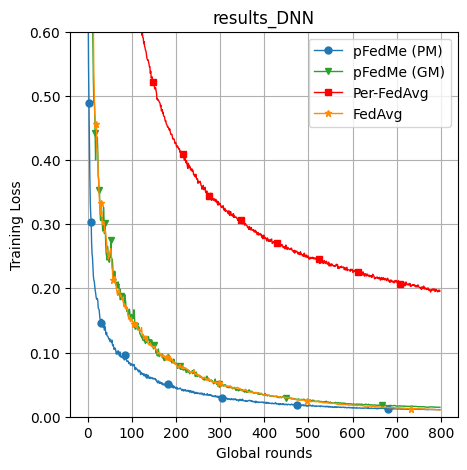

pFedMe (PM) 0.9651727861771059
pFedMe (GM) 0.9618790496760259
Per-FedAvg 0.9394438444924406
FedAvg 0.9598272138228943


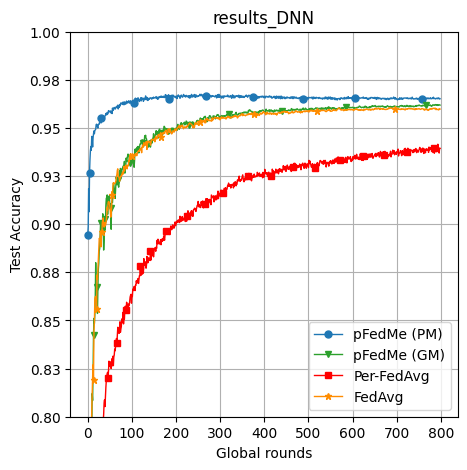

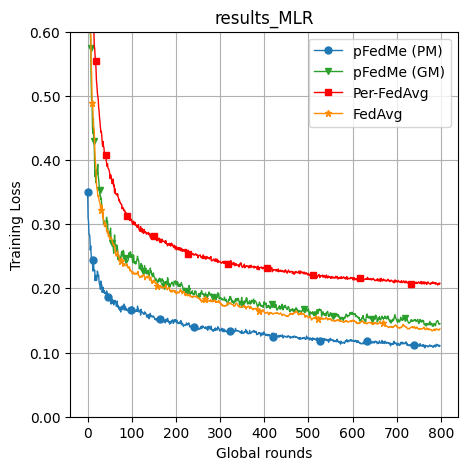

pFedMe (PM) 0.929535637149028
pFedMe (GM) 0.9166036717062633
Per-FedAvg 0.9293466522678185
FedAvg 0.922975161987041


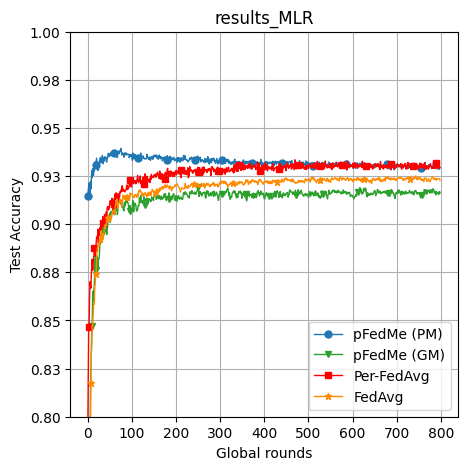

In [5]:
plot_comparison(num_users=num_users, folders=folders)

# Non-iidness

## Baseline

<img src="./results_images/datasets/baseline_train.png" alt="Distribution for the baseline" width="60%">

## Dirichlet

### $\alpha=1$

<img src="./results_images/datasets/dirichlet/mnist_train_D1.png" alt="Distribution for $\alpha=1$" width="60%">

In [6]:
folders = ["./results_dirichlet/alpha_1/results_DNN","./results_dirichlet/alpha_1/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.977372,784,0.964843,0.025950
1,pFedMe,results_DNN,0.974254,780,0.957834,0.047064
2,PerAvg_p,results_DNN,0.921102,794,0.883482,0.073450
3,FedAvg,results_DNN,0.971269,779,0.953888,0.043828
4,pFedMe_p,results_MLR,0.921695,796,0.913050,0.026775
5,pFedMe,results_MLR,0.914566,711,0.904454,0.037627
6,PerAvg_p,results_MLR,0.921055,774,0.905383,0.036125
7,FedAvg,results_MLR,0.919823,738,0.912985,0.032942


In [7]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
33,FedAvg,results_DNN,0.972348,796,0.972102,0.000198
70,FedAvg,results_MLR,0.922841,703,0.921982,0.000427
25,PerAvg_p,results_DNN,0.922241,794,0.921302,0.000436
61,PerAvg_p,results_MLR,0.922108,794,0.921482,0.000335
14,pFedMe,results_DNN,0.975613,778,0.975033,0.000322
53,pFedMe,results_MLR,0.918443,635,0.917497,0.000512
4,pFedMe_p,results_DNN,0.978745,784,0.977799,0.000396
44,pFedMe_p,results_MLR,0.923774,754,0.923108,0.000448


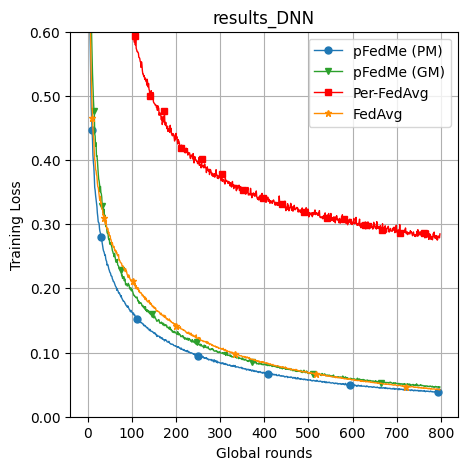

pFedMe (PM) 0.9759994669509595
pFedMe (GM) 0.973907249466951
Per-FedAvg 0.9168776652452026
FedAvg 0.9712486673773988


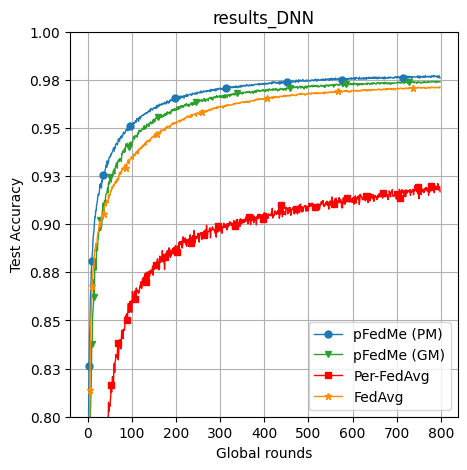

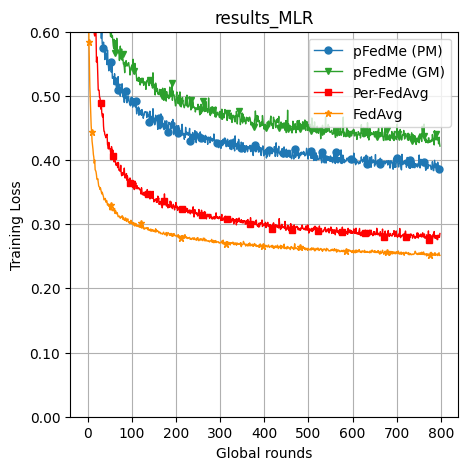

pFedMe (PM) 0.9206889658848614
pFedMe (GM) 0.9141191364605543
Per-FedAvg 0.9174307036247337
FedAvg 0.9189032515991471


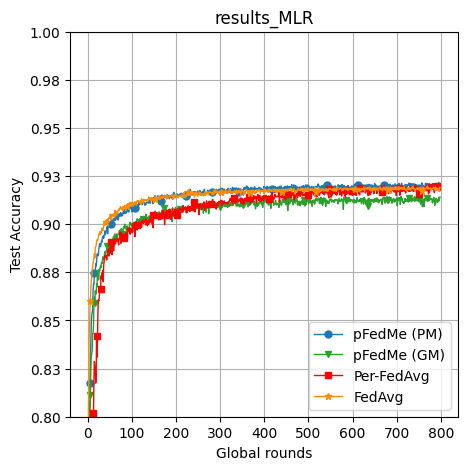

In [8]:
plot_comparison(num_users=num_users, folders=folders)

### $\alpha=0.5$

<img src="./results_images/datasets/dirichlet/mnist_train_D0_5.png" alt="Distribution for $\alpha=0.5$" width="60%">

In [9]:
folders = ["./results_dirichlet/alpha_0_5/results_DNN","./results_dirichlet/alpha_0_5/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.979724,784,0.967467,0.022844
1,pFedMe,results_DNN,0.976559,796,0.957592,0.049178
2,PerAvg_p,results_DNN,0.925360,775,0.892383,0.068354
3,FedAvg,results_DNN,0.972588,792,0.952724,0.046895
4,pFedMe_p,results_MLR,0.923534,767,0.915176,0.023381
5,pFedMe,results_MLR,0.913186,781,0.902079,0.038613
6,PerAvg_p,results_MLR,0.924594,610,0.911845,0.031827
7,FedAvg,results_MLR,0.920103,655,0.911180,0.034674


In [10]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
35,FedAvg,results_DNN,0.974147,794,0.973454,0.000337
70,FedAvg,results_MLR,0.923441,666,0.923061,0.000211
20,PerAvg_p,results_DNN,0.926373,775,0.925606,0.000456
64,PerAvg_p,results_MLR,0.925573,610,0.925193,0.000260
10,pFedMe,results_DNN,0.977878,792,0.977279,0.000390
59,pFedMe,results_MLR,0.917377,730,0.915985,0.000601
1,pFedMe_p,results_DNN,0.980610,774,0.980084,0.000313
49,pFedMe_p,results_MLR,0.925973,730,0.925027,0.000513


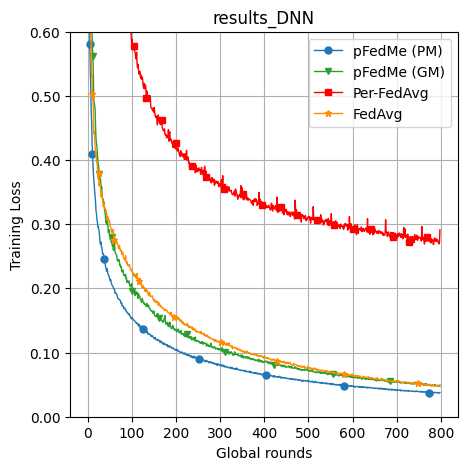

pFedMe (PM) 0.9790711620469084
pFedMe (GM) 0.9752665245202559
Per-FedAvg 0.9153917910447762
FedAvg 0.9725879530916843


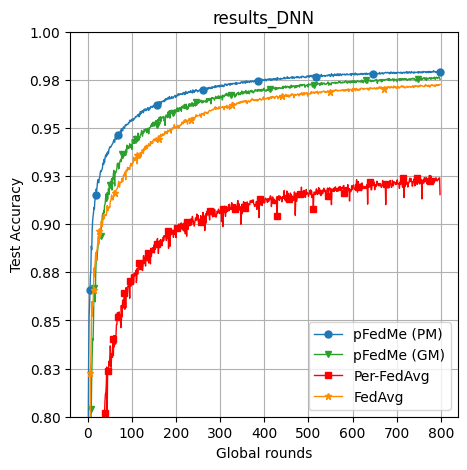

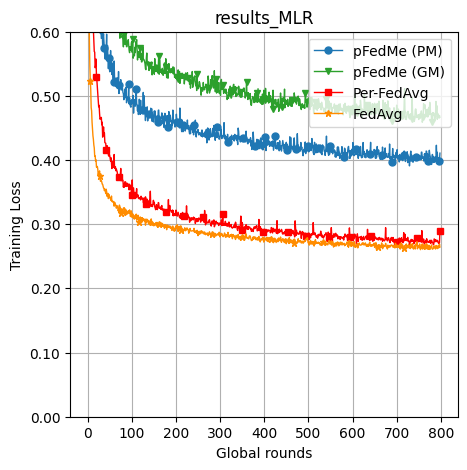

pFedMe (PM) 0.920495735607676
pFedMe (GM) 0.911793710021322
Per-FedAvg 0.9150053304904052
FedAvg 0.9166311300639659


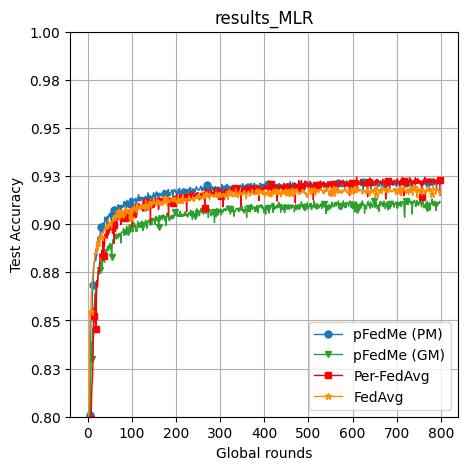

In [11]:
plot_comparison(num_users=num_users, folders=folders)

### $\alpha=0.2$

<img src="./results_images/datasets/dirichlet/mnist_train_D0_2.png" alt="Distribution for $\alpha=0.2$" width="60%">

In [12]:
folders = ["./results_dirichlet/alpha_0_2/results_DNN","./results_dirichlet/alpha_0_2/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.979379,780,0.967128,0.020793
1,pFedMe,results_DNN,0.973163,798,0.950380,0.055186
2,PerAvg_p,results_DNN,0.925645,781,0.895766,0.057138
3,FedAvg,results_DNN,0.914285,791,0.901413,0.038465
4,pFedMe_p,results_MLR,0.926457,571,0.918378,0.020592
5,pFedMe,results_MLR,0.907555,731,0.894365,0.040768
6,PerAvg_p,results_MLR,0.924519,799,0.910808,0.030203
7,FedAvg,results_MLR,0.913352,690,0.901412,0.038657


In [13]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
32,FedAvg,results_DNN,0.918316,509,0.917556,0.000500
77,FedAvg,results_MLR,0.918316,773,0.917736,0.000492
27,PerAvg_p,results_DNN,0.926711,781,0.925698,0.000614
63,PerAvg_p,results_MLR,0.925378,799,0.924612,0.000289
17,pFedMe,results_DNN,0.975481,798,0.974162,0.000574
56,pFedMe,results_MLR,0.911786,629,0.910734,0.000599
7,pFedMe_p,results_DNN,0.981211,786,0.979799,0.000591
44,pFedMe_p,results_MLR,0.928576,688,0.928210,0.000406


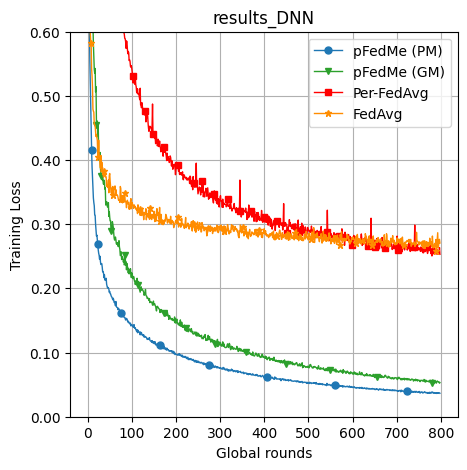

pFedMe (PM) 0.9785861816243587
pFedMe (GM) 0.9725098274368712
Per-FedAvg 0.9240322473182758
FedAvg 0.9095476047704711


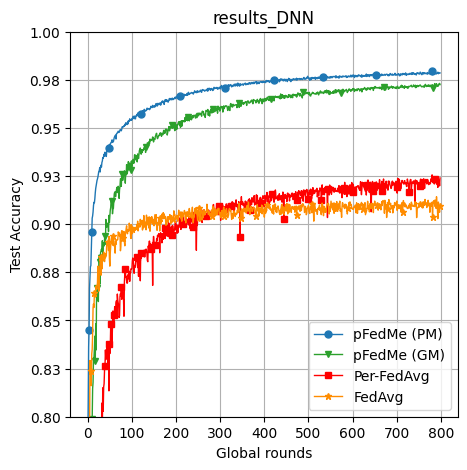

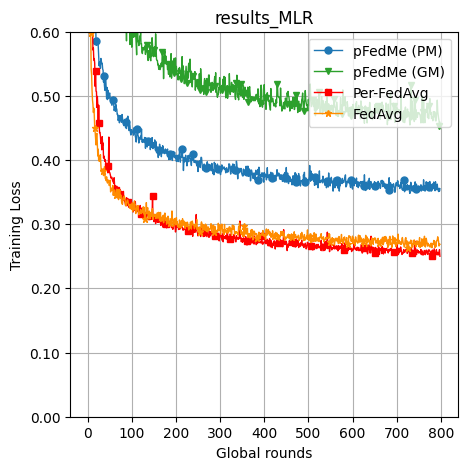

pFedMe (PM) 0.924332067426211
pFedMe (GM) 0.9064228129788793
Per-FedAvg 0.9245186221600374
FedAvg 0.9097608101805583


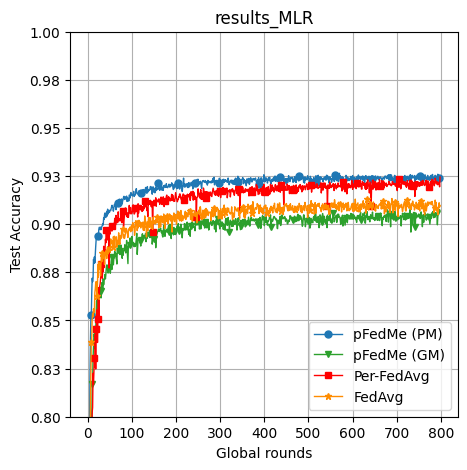

In [14]:
plot_comparison(num_users=num_users, folders=folders)

### $\alpha=0.05$

<img src="./results_images/datasets/dirichlet/mnist_train_0_05.png" alt="Distribution for $\alpha=0.05$" width="60%">

In [15]:
folders = ["./results_dirichlet/alpha_0_05/results_DNN","./results_dirichlet/alpha_0_05/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.985228,791,0.978493,0.008058
1,pFedMe,results_DNN,0.966824,782,0.920681,0.090685
2,PerAvg_p,results_DNN,0.959835,678,0.945196,0.023001
3,FedAvg,results_DNN,0.944430,799,0.881236,0.084718
4,pFedMe_p,results_MLR,0.946255,651,0.939469,0.008309
5,pFedMe,results_MLR,0.892731,771,0.863722,0.063975
6,PerAvg_p,results_MLR,0.958915,525,0.949650,0.013682
7,FedAvg,results_MLR,0.890698,522,0.853073,0.060769


In [16]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
32,FedAvg,results_DNN,0.956090,784,0.953272,0.001486
73,FedAvg,results_MLR,0.909382,664,0.907323,0.001202
26,PerAvg_p,results_DNN,0.962753,635,0.961247,0.001070
61,PerAvg_p,results_MLR,0.961354,236,0.960568,0.000633
10,pFedMe,results_DNN,0.971682,797,0.970123,0.000748
50,pFedMe,results_MLR,0.904651,796,0.902765,0.000791
7,pFedMe_p,results_DNN,0.987007,676,0.986401,0.000384
49,pFedMe_p,results_MLR,0.951093,798,0.949973,0.000560


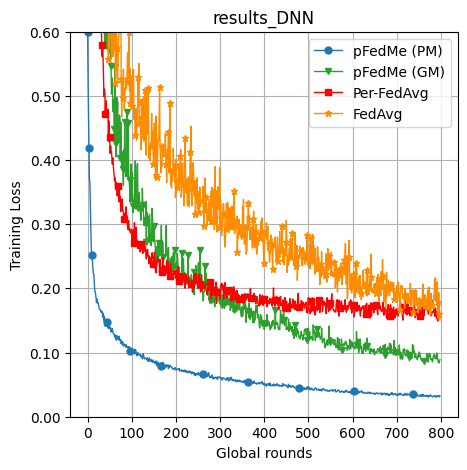

pFedMe (PM) 0.9841151385927505
pFedMe (GM) 0.9648054371002133
Per-FedAvg 0.9502065565031984
FedAvg 0.9444296375266525


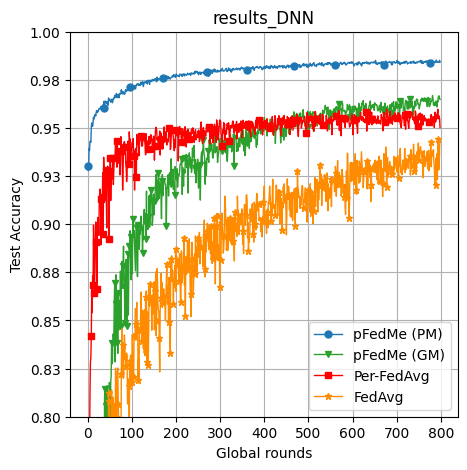

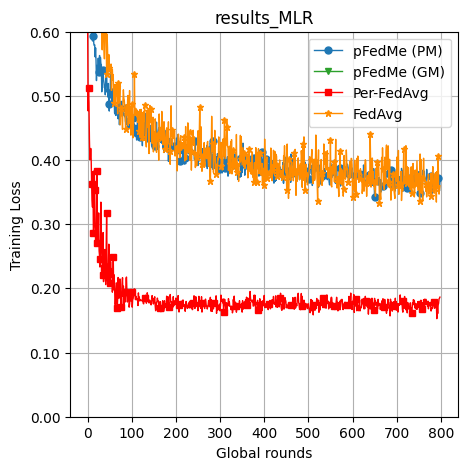

pFedMe (PM) 0.9430570362473347
pFedMe (GM) 0.8863272921108741
Per-FedAvg 0.9485740938166313
FedAvg 0.8779584221748401


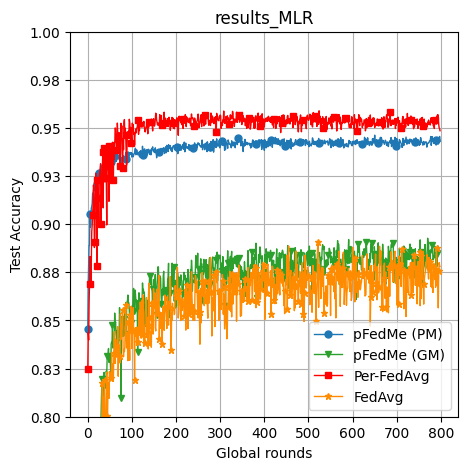

In [17]:
plot_comparison(num_users=num_users, folders=folders)

# Attacks

- **Strongly Convex Case:** referred as MLR
    - pFedMe:
        ```
        python3 attacks.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.1 --beta 2 --lamda 15 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 attacks.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 attacks.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.03 --beta 0.003  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

- **Non-Convex Case:** referred as DNN
    - pFedMe:
        ```
        python3 attacks.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.05 --beta 2 --lamda 30 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 attacks.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 attacks.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --beta 0.001  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

In [18]:
num_users = 5
folders = ["./results_attacks/results_DNN", "./results_attacks/results_MLR"]
#folders = ["./results_attacks/results_MLR"]
#folders = ["./results_attacks/results_DNN"]

## Average

In [19]:
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.938796,0,0.110663,0.051676
1,pFedMe,results_DNN,0.278915,4,0.105869,0.013667
2,PerAvg_p,results_DNN,0.732586,38,0.585016,0.078052
3,FedAvg,results_DNN,0.400027,3,0.109110,0.030311
4,pFedMe_p,results_MLR,0.856129,0,0.568576,0.019498
5,pFedMe,results_MLR,0.581371,12,0.552401,0.023144
6,PerAvg_p,results_MLR,0.746922,2,0.561296,0.026576
7,FedAvg,results_MLR,0.652511,7,0.561388,0.026303


## Training rounds

In [20]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
36,FedAvg,results_DNN,0.740551,5,0.531965,0.136621
71,FedAvg,results_MLR,0.909827,133,0.768359,0.210363
26,PerAvg_p,results_DNN,0.926026,320,0.806237,0.099294
61,PerAvg_p,results_MLR,0.922516,57,0.836987,0.061543
11,pFedMe,results_DNN,0.676296,5,0.431263,0.127955
50,pFedMe,results_MLR,0.919276,80,0.720275,0.199997
1,pFedMe_p,results_DNN,0.952754,0,0.938796,0.021737
40,pFedMe_p,results_MLR,0.940875,43,0.857748,0.081467


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 500x500 with 1 Axes>

pFedMe (PM) 0.10421166306695465
pFedMe (GM) 0.10421166306695465
Per-FedAvg 0.46968142548596115
FedAvg 0.10421166306695465


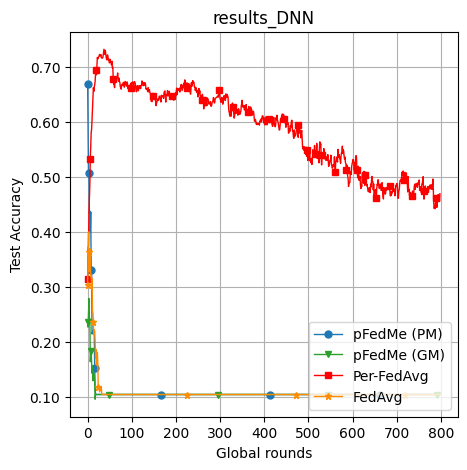

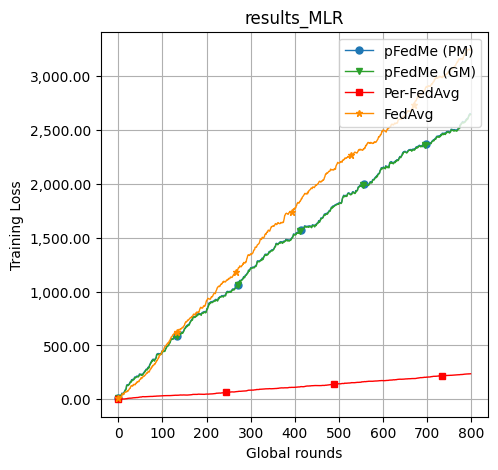

pFedMe (PM) 0.5693304535637148
pFedMe (GM) 0.5645518358531317
Per-FedAvg 0.552402807775378
FedAvg 0.5642008639308854


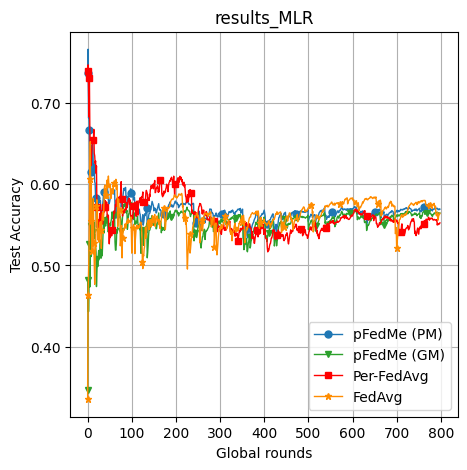

In [21]:
plot_comparison(num_users=num_users, folders=folders, y_lim=False)

In [22]:

hf = h5py.File('results_attacks/results_DNN/Mnist_PerAvg_p_0.02_0.001_15_5u_20b_20_avg.h5', 'r')
rs_glob_acc = np.array(hf.get('rs_glob_acc')[:])
rs_train_acc = np.array(hf.get('rs_train_acc')[:])
rs_train_loss = np.array(hf.get('rs_train_loss')[:])
print(rs_train_acc, rs_train_loss[~np.isnan(rs_train_loss)], rs_glob_acc)


[0.29634345 0.29599133 0.34976526 0.36312748 0.41379559 0.4476887
 0.47467497 0.52004334 0.54534128 0.56602564 0.57297761 0.59301192
 0.61176417 0.6317082  0.65162514 0.64478151 0.65419827 0.65793608
 0.66460816 0.68039906 0.6849675  0.67689599 0.69206392 0.70566089
 0.70353918 0.70665403 0.71010293 0.71112315 0.71500542 0.71454496
 0.71377754 0.71452691 0.71115023 0.70847779 0.70926327 0.71042795
 0.712026   0.72025099 0.725316   0.71944745 0.71472553 0.72278801
 0.71519502 0.70910979 0.70575117 0.70481221 0.71561936 0.71338028
 0.70565186 0.70676237 0.70277176 0.6992416  0.70527266 0.69914229
 0.70222102 0.69730047 0.70195919 0.69281329 0.69338209 0.67355544
 0.66018418 0.6595883  0.65586854 0.66552004 0.67100036 0.67189419
 0.67038642 0.6760112  0.67615565 0.68264717 0.67026905 0.66885157
 0.67332972 0.66792163 0.66486999 0.65834236 0.65732214 0.65438787
 0.65903756 0.66287468 0.66325388 0.66245034 0.66644998 0.66171903
 0.65860419 0.6628476  0.66773203 0.66388588 0.66498736 0.65938